In [1]:

import numpy as np
import pandas as pd
import eli5
import pickle
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.linear_model import , SGDRegressor
from sklearn.linear_model import SGDClassifier
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

import datetime
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv(r'D:\Загрузки\train_sessions.csv\train_sessions.csv', index_col='session_id')
#D:\Загрузки\train_sessions.csv\train_sessions.csv     из красного 
# C:\Users\ILYA\Downloads\train_sessions.csv (1)\train_sessions.csv    из серого

In [3]:
test_df = pd.read_csv(r'D:\Загрузки\test_sessions.csv\test_sessions.csv', index_col='session_id')
# D:\Загрузки\test_sessions.csv\test_sessions.csv   из красного 
# C:\Users\ILYA\Downloads\test_sessions.csv (1)\test_sessions.csv из серого 

In [4]:
# В обучающей выборке train_sessions.csv:

# Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
# Признаки time_j – время посещения сайтов site_j
# Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [7]:
train_df.target.value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [8]:
train_df.query('target==1')

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
153,5397,2013-11-22 13:23:49,5395.0,2013-11-22 13:23:49,22.0,2013-11-22 13:23:50,5396.0,2013-11-22 13:23:50,5402.0,2013-11-22 13:23:50,...,2013-11-22 13:23:50,22.0,2013-11-22 13:23:51,35.0,2013-11-22 13:23:54,33.0,2013-11-22 13:23:54,338.0,2013-11-22 13:23:54,1
287,10941,2014-03-24 17:34:14,9783.0,2014-03-24 17:34:14,9786.0,2014-03-24 17:34:14,27339.0,2014-03-24 17:34:14,27338.0,2014-03-24 17:34:15,...,2014-03-24 17:34:15,27339.0,2014-03-24 17:34:15,9783.0,2014-03-24 17:34:15,9785.0,2014-03-24 17:34:15,10941.0,2014-03-24 17:34:15,1
430,37,2014-02-13 12:46:49,270.0,2014-02-13 12:48:14,32.0,2014-02-13 12:48:17,33.0,2014-02-13 12:48:18,35.0,2014-02-13 12:48:18,...,2014-02-13 12:48:23,29.0,2014-02-13 12:48:25,33.0,2014-02-13 12:48:48,12623.0,2014-02-13 12:48:48,704.0,2014-02-13 12:48:48,1
644,39,2014-02-17 16:42:03,23.0,2014-02-17 16:42:06,677.0,2014-02-17 16:42:08,22.0,2014-02-17 16:42:12,39.0,2014-02-17 16:42:12,...,2014-02-17 16:42:12,21.0,2014-02-17 16:42:12,678.0,2014-02-17 16:42:13,22.0,2014-02-17 16:42:15,678.0,2014-02-17 16:42:17,1
682,77,2013-09-12 16:21:55,879.0,2013-09-12 16:21:56,80.0,2013-09-12 16:21:58,879.0,2013-09-12 16:21:58,80.0,2013-09-12 16:22:04,...,2013-09-12 16:22:06,77.0,2013-09-12 16:22:10,879.0,2013-09-12 16:22:13,879.0,2013-09-12 16:22:14,80.0,2013-09-12 16:22:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252790,80,2013-11-29 12:51:26,879.0,2013-11-29 12:51:32,879.0,2013-11-29 12:51:36,879.0,2013-11-29 12:51:47,80.0,2013-11-29 12:51:56,...,2013-11-29 12:52:05,76.0,2013-11-29 12:52:25,80.0,2013-11-29 12:52:27,80.0,2013-11-29 12:52:45,80.0,2013-11-29 12:52:53,1
252850,2271,2013-11-29 13:02:30,37.0,2013-11-29 13:02:58,17283.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:21,...,2013-11-29 13:03:21,17283.0,2013-11-29 13:03:21,143.0,2013-11-29 13:03:21,33.0,2013-11-29 13:03:21,18876.0,2013-11-29 13:03:21,1
253140,4694,2014-03-24 16:52:50,27332.0,2014-03-24 16:52:52,2409.0,2014-03-24 16:52:52,27332.0,2014-03-24 16:52:53,2401.0,2014-03-24 16:52:53,...,2014-03-24 16:52:54,27332.0,2014-03-24 16:52:55,4696.0,2014-03-24 16:52:57,27332.0,2014-03-24 16:52:57,2401.0,2014-03-24 16:52:59,1


In [9]:
train_df.shape

(253561, 21)

In [10]:
test_df.shape

(82797, 20)

In [11]:
#Создание единого фрейма для удобства разработки фич, без повтора на тестовую выборку отдельно 

In [12]:
#отделить таргет от Трэйна и содеинить Трэйн с Тестом. Сумма строк составит 336 358

In [13]:
DF_Full = pd.concat([train_df.drop('target', axis=1), test_df])

In [14]:
DF_Full.shape

(336358, 20)

In [15]:
DF_Full.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


In [16]:
site = ['site%s' % i for i in range(1,11)]
DF_Full2Time = DF_Full.drop(site, axis=1)
for i in range(DF_Full2Time.shape[1]):
    DF_Full2Time.iloc[:,i] = pd.to_datetime(DF_Full2Time.iloc[:,i])

#DF_Full2Time = DF_Full2Time.fillna(pd.Timedelta(seconds=0))
#DF_Full2Time = DF_Full2Time.fillna(0) #.astype(str)


# #  pd.to_datetime
# DF_Full2Time['nonzeroval'] = pd.to_datetime(DF_Full2Time.time2) #[year, month, day]
# # apply(lambda x: x[0].timestamp(), axis=1).astype(int)
# # DF_Full2Time['nonzeroval'] = DF_Full2Time.nonzeroval.astype(str)

DF_Full2Time['delta'] = DF_Full2Time.max(axis = 1) - DF_Full2Time.min(axis = 1)

# DF_Full2Time = DF_Full2Time.fillna(0) #.astype(str)
#DF_Full2Time['count_steps'] = (DF_Full2Time == 0).astype(int).sum(axis=1)
DF_Full2Time

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,delta
session_id,,,,,,,,,,,
1,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16,0 days 00:00:26
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24,0 days 00:00:07
4,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42,0 days 00:04:30
5,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11,0 days 00:04:06
...,...,...,...,...,...,...,...,...,...,...,...
82793,2014-10-02 18:20:09,2014-10-02 18:20:09,2014-10-02 18:20:09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00
82794,2014-05-26 14:16:40,2014-05-26 14:16:41,2014-05-26 14:16:44,2014-05-26 14:16:44,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,0 days 00:00:39
82795,2014-05-02 11:21:56,2014-05-02 11:21:56,2014-05-02 11:21:56,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:04,2014-05-02 11:22:04,2014-05-02 11:22:04,0 days 00:00:08


In [17]:
#Анализ предполагаемых фич 

In [18]:
#Анализ распределения врмени посещения трэйне 
si = ['site%s' % i for i in range(1,11)]
ti = ['time%s' % i for i in range(1,11)]
TrainDistribTime = train_df.drop(si, axis=1)
TrainDistribTime = TrainDistribTime.drop('target', axis=1)
TrainDistribTime = TrainDistribTime.fillna('0')

for col in TrainDistribTime:
    TrainDistribTime[col] = TrainDistribTime[col].apply(lambda x: x[:8]).apply(lambda x: x.replace('-', '')).astype(int)


D:\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


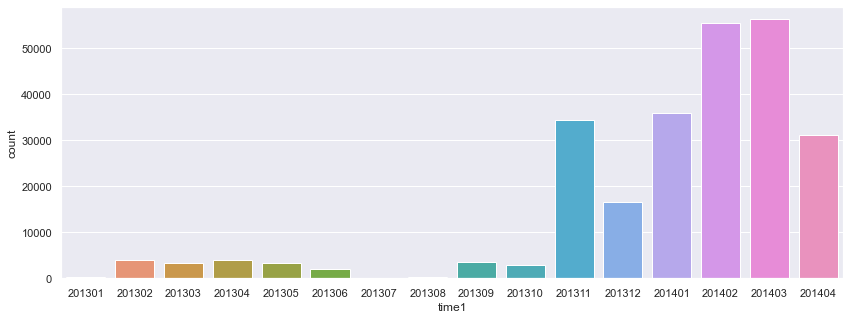

In [19]:
sns.set(rc={'figure.figsize':(14, 5)})
sns.countplot(TrainDistribTime.time1);

In [20]:
si = ['site%s' % i for i in range(1,11)]
ti = ['time%s' % i for i in range(1,11)]
TestnDistribTime = test_df.drop(si, axis=1)
# TestnDistribTime = TestnDistribTime.drop('target', axis=1)
TestnDistribTime = TestnDistribTime.fillna('0')

for col in TestnDistribTime:
    TestnDistribTime[col] = TestnDistribTime[col].apply(lambda x: x[:8]).apply(lambda x: x.replace('-', '')).astype(int)

D:\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


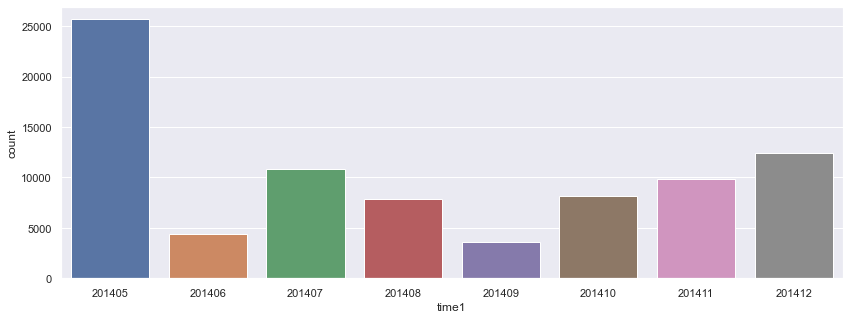

In [21]:
sns.countplot(TestnDistribTime.time1);

In [22]:

#В какое время элис начинает сидеть за компом
A_time = pd.DataFrame({'time': train_df.time1.apply(lambda x: x[11:13]).astype(int), 'Alice': train_df.target}).set_index('time')

<AxesSubplot:xlabel='time', ylabel='count'>

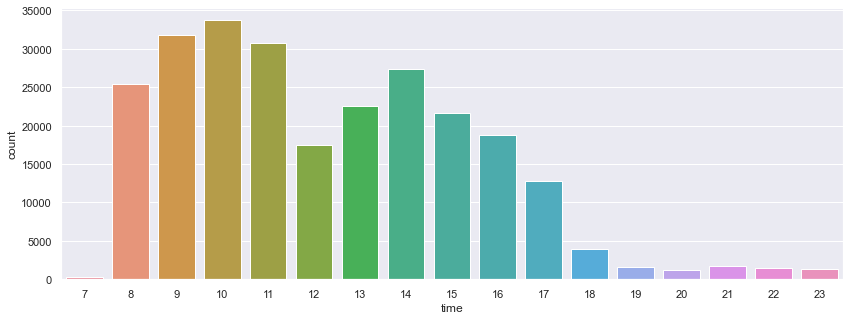

In [23]:
#Общий график активности 
sns.countplot(x=A_time.index) 


<AxesSubplot:xlabel='time', ylabel='count'>

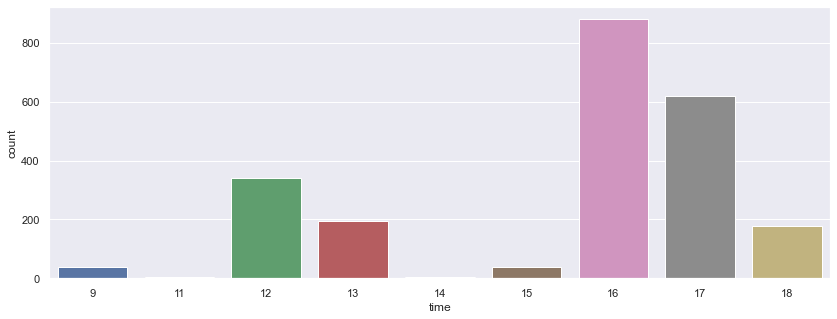

In [24]:
Only_Alic = A_time.query('Alice==1')
sns.countplot(x = Only_Alic.index)

In [25]:
#Поиск месяцев Элис
A_start_mounth= pd.DataFrame({'month': train_df.time1.apply(lambda x: x[5:7]).astype(int), 'Alice': train_df.target}).set_index('month')

<AxesSubplot:xlabel='month', ylabel='count'>

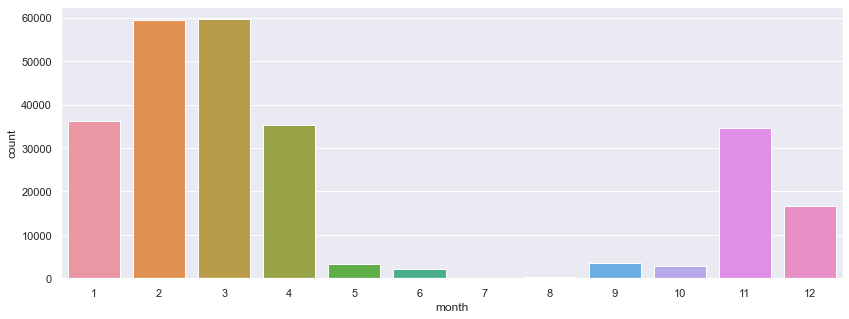

In [26]:
#Общий график активности по месяцам, у кого в какой месяц началаст первая сессия
sns.countplot(x=A_start_mounth.index) 

<AxesSubplot:xlabel='month', ylabel='count'>

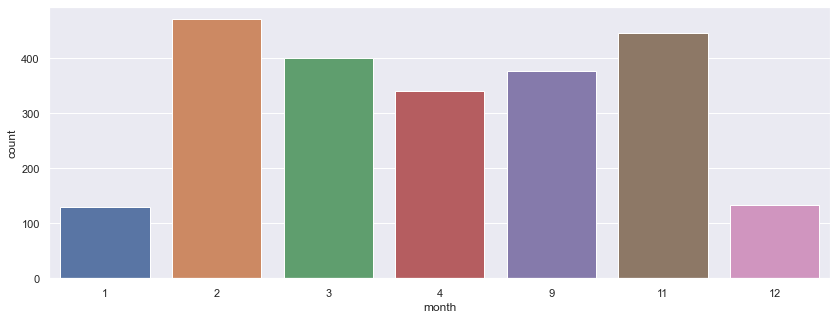

In [27]:
Only_Alic2 = A_start_mounth.query('Alice==1')
sns.countplot(x = Only_Alic2.index)

<AxesSubplot:xlabel='count_steps', ylabel='count'>

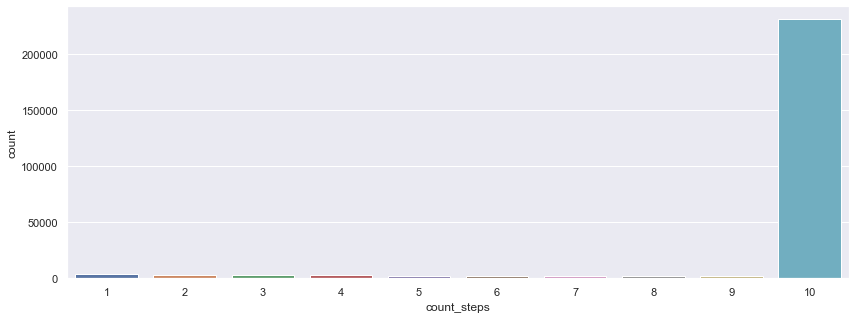

In [28]:
#Поиск сколько шагов сделала элис
time = ['time%s' % i for i in range(1,11)]
A_count_step = train_df.drop(time, axis=1)
A_count_step = A_count_step.drop('target', axis=1)
A_count_step=A_count_step.fillna(0)
A_count_step['count_steps'] = 10-(A_count_step == 0).astype(int).sum(axis=1)
A_count_step['Alice'] = train_df.target
A_count_step_finall = A_count_step[['count_steps', 'Alice']].set_index('count_steps')
sns.countplot(x=A_count_step_finall.index)

In [29]:
Only_Alic3 = A_count_step_finall.query('Alice==1')
Only_Alic3.value_counts()
# sns.countplot(x = Only_Alic3.index)

Alice
1        2297
dtype: int64

In [30]:
#Количество уникальных сайтов которые посещает элис за сессиию 
time = ['time%s' % i for i in range(1,11)]
DFforUniqSItes = train_df.drop(time, axis=1)
DFforUniqSItes = DFforUniqSItes.drop('target', axis=1)
UniqSitesPerSes = pd.DataFrame({'num_uniq_sites': DFforUniqSItes.apply(pd.Series.nunique, axis=1)})

In [31]:
UniqSitesPerSes['Alice'] = train_df.target
UniqSitesPerSes = UniqSitesPerSes.set_index('num_uniq_sites')

<AxesSubplot:xlabel='num_uniq_sites', ylabel='count'>

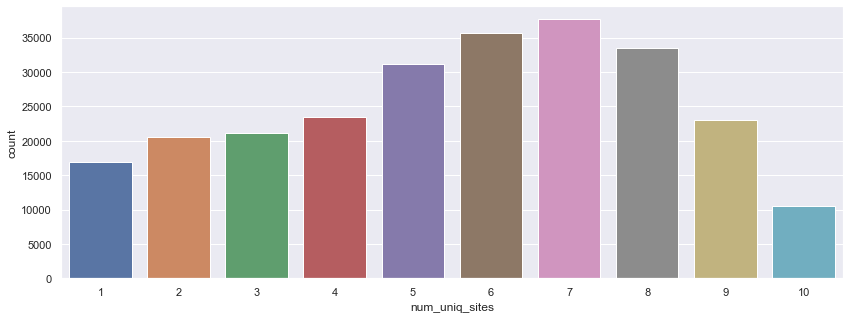

In [32]:
sns.countplot(x=UniqSitesPerSes.index) 

<AxesSubplot:xlabel='num_uniq_sites', ylabel='count'>

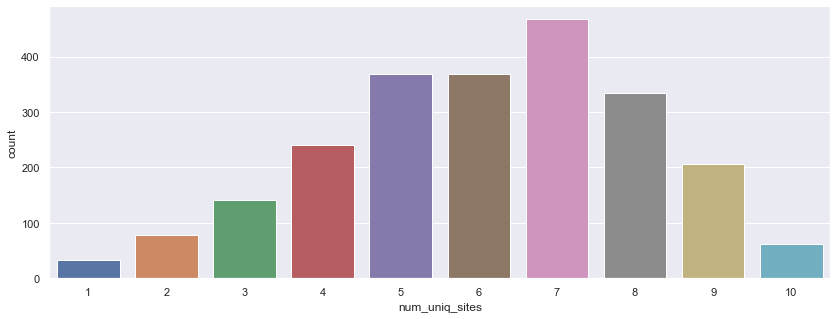

In [33]:
Only_Alic4 = UniqSitesPerSes.query('Alice==1')
sns.countplot(x = Only_Alic4.index)

In [34]:
# Поиск паттернов поведения Элис 
time = ['time%s' % i for i in range(1,11)]
AlicesLoveSites = train_df.drop(time, axis=1)
AlicesLoveSites = AlicesLoveSites.query('target == 1')
AlicesLoveSites =  AlicesLoveSites.drop('target', axis=1)
AlicesLoveSites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
153,5397,5395.0,22.0,5396.0,5402.0,5392.0,22.0,35.0,33.0,338.0
287,10941,9783.0,9786.0,27339.0,27338.0,29.0,27339.0,9783.0,9785.0,10941.0
430,37,270.0,32.0,33.0,35.0,704.0,29.0,33.0,12623.0,704.0
644,39,23.0,677.0,22.0,39.0,23.0,21.0,678.0,22.0,678.0
682,77,879.0,80.0,879.0,80.0,879.0,77.0,879.0,879.0,80.0
...,...,...,...,...,...,...,...,...,...,...
252790,80,879.0,879.0,879.0,80.0,80.0,76.0,80.0,80.0,80.0
252850,2271,37.0,17283.0,29.0,29.0,30.0,17283.0,143.0,33.0,18876.0
253140,4694,27332.0,2409.0,27332.0,2401.0,27332.0,27332.0,4696.0,27332.0,2401.0


In [35]:
AlicesLoveSites['MostPopSiteperSes'] = pd.DataFrame({'a': AlicesLoveSites.mode(axis=1)[0]})
# lovasite = pd.DataFrame({'love_unique_sites': AlicesLoveSites.MostPopSiteperSes.unique()})
# lovasite
AlicesLoveSites.MostPopSiteperSes.value_counts().head(30)


76.0       205
77.0       170
21.0       168
29.0       129
80.0       103
75.0        65
81.0        62
22.0        62
879.0       55
23.0        52
3000.0      50
82.0        47
881.0       43
7832.0      35
855.0       34
3.0         34
733.0       33
2078.0      32
941.0       31
37.0        24
30.0        23
12619.0     21
1514.0      20
3559.0      18
616.0       17
704.0       17
52.0        16
27307.0     14
2077.0      14
335.0       14
Name: MostPopSiteperSes, dtype: int64

In [36]:
#общее время в сети для элис 
AliceTime = pd.DataFrame({'FullTime': DF_Full2Time[:253561].delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")), 'Alice': train_df.target})

In [37]:
NotAlic5 = AliceTime.query('Alice==0')
NotAlic5.FullTime.value_counts().head(10)

0002    14380
0001    10750
0003    10273
0004     7960
0000     6692
0005     6533
0006     5696
0009     5294
0007     5057
0008     4649
Name: FullTime, dtype: int64

In [38]:
Only_Alic5 = AliceTime.query('Alice==1')
Only_Alic5.FullTime.value_counts().head(30)

0003    186
0004    166
0002    144
0005    112
0006    101
0008     81
0007     80
0009     79
0001     76
0010     57
0011     54
0012     41
0013     41
0016     40
0014     38
0015     34
0018     31
0023     24
0020     24
0017     24
0021     22
0026     21
0033     21
0019     20
0022     20
0000     19
0029     17
0025     17
0032     16
0043     16
Name: FullTime, dtype: int64

In [39]:
#Какие сайты Элис вообще не посещает 

In [40]:
# Посмотрим на пикл


with open('D:\Загрузки\site_dic.pkl\site_dic.pkl', 'rb') as f:
    dictofsites = pickle.load(f)

In [41]:
len(dictofsites)

48371

In [42]:

#Вывести список уникальных сайтов в трейне для людей не Элис и список уникальных для Элис, сравнить, на каких Элис вообще не была 
time = ['time%s' % i for i in range(1,11)]
AliceDontLoveSite = train_df.drop(time, axis=1)
AliceDontLoveSite.site1 = AliceDontLoveSite.site1.astype(int)
AliceSitesGo = AliceDontLoveSite.query('target  == 1')
AliceSitesGo = AliceSitesGo.drop('target', axis=1)

NOTAliceSitesGo = AliceDontLoveSite.query('target  == 0')
NOTAliceSitesGo = NOTAliceSitesGo.drop('target', axis=1)

In [43]:
# AliceSitesGo
AliceUniqueSites = pd.DataFrame({'Site' :pd.concat([AliceSitesGo['site1'], AliceSitesGo['site2'], AliceSitesGo['site3'], AliceSitesGo['site4'],
AliceSitesGo['site5'], AliceSitesGo['site6'], AliceSitesGo['site7'], AliceSitesGo['site8'], AliceSitesGo['site9'], AliceSitesGo['site10']
]).unique()})

# AliceUniqueSites[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']].apply(lambda x: ''.join(x), axis=1)

# pd.unique(AliceUniqueSites[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']].values)

# df343= AliceUniqueSites.drop_duplicates (subset = ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10'])

# df = df.drop_duplicates (subset = ['C1', 'C2', 'C3'])
# AliceUniqueSitesArray  = pd.concat([AliceSitesGo['site1'], AliceSitesGo['site2'], AliceSitesGo['site3'], AliceSitesGo['site4'],
# AliceSitesGo['site5'], AliceSitesGo['site6'], AliceSitesGo['site7'], AliceSitesGo['site8'], AliceSitesGo['site9'], AliceSitesGo['site10']
# ]).unique()

In [44]:
AliceUniqueSites.sort_values(by='Site').head(10)

,Site
79,1.0
150,2.0
102,3.0
277,4.0
293,6.0
259,7.0
46,8.0
422,10.0
81,11.0
126,12.0


In [45]:
NOTAUniqueSites = pd.DataFrame({'Site' :pd.concat([NOTAliceSitesGo['site1'], NOTAliceSitesGo['site2'], NOTAliceSitesGo['site3'], NOTAliceSitesGo['site4'],
NOTAliceSitesGo['site5'], NOTAliceSitesGo['site6'], NOTAliceSitesGo['site7'], NOTAliceSitesGo['site8'], NOTAliceSitesGo['site9'], NOTAliceSitesGo['site10']
]).unique()})
NOTAUniqueSites.sort_values(by='Site').head(10)

,Site
60,1.0
524,2.0
37,3.0
522,4.0
892,5.0
66,6.0
412,7.0
562,8.0
12787,9.0
1356,10.0


In [46]:
# SitesWhichAliceNeverUse = pd.concat([AliceUniqueSites, NOTAUniqueSites])
SitesWhichAliceNeverUse = pd.concat([AliceUniqueSites, NOTAUniqueSites])
counts = SitesWhichAliceNeverUse.Site.value_counts()[SitesWhichAliceNeverUse.Site.value_counts() < 2]
new_list = counts.index.tolist()

In [47]:
len(new_list)

40738

In [48]:
new_list3 = new_list[:3000]

In [49]:
len(new_list[:1000])

1000

In [50]:
AliceDontUSE = pd.DataFrame({'SiteID': new_list}).sort_values(by='SiteID')

In [51]:
AliceDontUSE

,SiteID
38057,5.0
36479,9.0
6653,19.0
12399,24.0
5033,25.0
...,...
11697,41597.0
11330,41598.0
2716,41599.0
34560,41600.0


In [52]:
#Попытка замены 3000 элементов
# time = ['time%s' % i for i in range(1,11)]
# AliceDUS = train_df.drop(time, axis=1)
# AliceDUS = AliceDUS.drop('target', axis=1)
# # AliceDUS
# new_list2 = [718, 890]
# AliceDUS.replace(new_list3, 0) #при замене 3000 сайтов нулями работает, дальше не хватит оперативки в 16 гб, не хвататет оперативки 

In [108]:
time = ['time%s' % i for i in range(1,11)]
AliceAverageSumSites = train_df.drop(time, axis=1)
AliceAverageSumSites = AliceAverageSumSites.drop('target', axis=1)
AliceAverageSumSites['Sum'] = AliceAverageSumSites.sum(axis=1)
AliceAverageSumSites['target'] = train_df.target
AliceAverageSumSites= AliceAverageSumSites.drop(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10'], axis=1)
Al = AliceAverageSumSites.query('target==1').drop('target', axis=1)
NotAl = AliceAverageSumSites.query('target==0').drop('target', axis=1)

array([[<AxesSubplot:title={'center':'Sum'}>]], dtype=object)

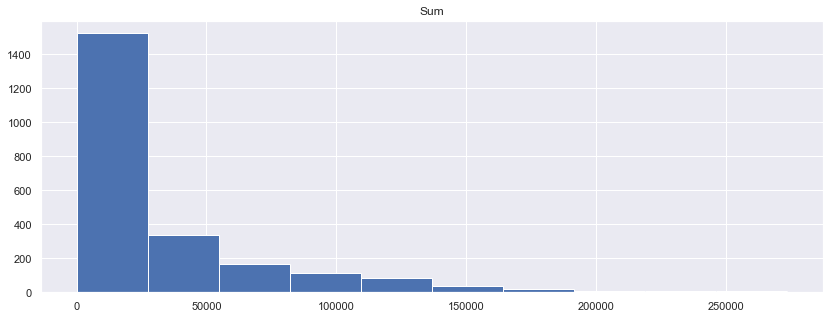

In [110]:
Al.hist()

In [118]:
Al.describe()

,Sum
count,2297.000000
mean,30003.860253
std,41785.878732
min,59.000000
25%,2650.000000
50%,13018.000000
75%,38876.000000
max,273677.000000


array([[<AxesSubplot:title={'center':'Sum'}>]], dtype=object)

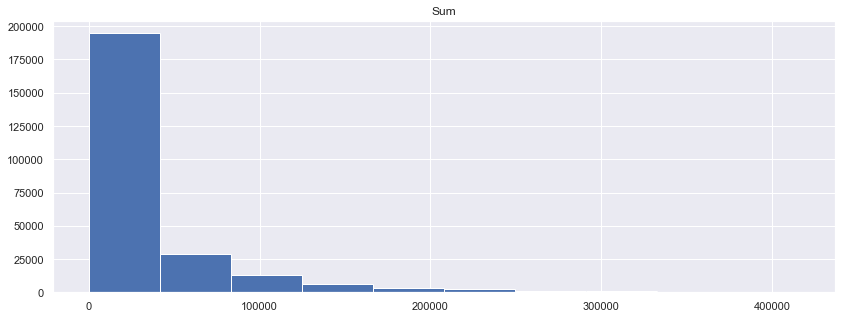

In [157]:
NotAl.hist()

In [113]:
NotAl.describe()

,Sum
count,251264.000000
mean,31938.997377
std,52280.337281
min,1.000000
25%,3784.000000
50%,9394.500000
75%,36836.000000
max,415970.000000


In [53]:
# SitesWhichAliceNeverUse = SitesWhichAliceNeverUse.drop_duplicates()
# SitesWhichAliceNeverUse.sort_values(by='Site').head(50) #ГАВНО 

In [158]:
#ФСоздание новых фич
time = ['time%s' % i for i in range(1,11)]
DF_Full1 = DF_Full.drop(time, axis=1)

In [159]:
#Способ1 Лучшая

# DF_Full1=DF_Full1.fillna(0)
DF_Full1.site1 = DF_Full1.site1.astype(float)

#Число уникальных сайтов в сессии
DF_Full1['num_uniq_sites'] = DF_Full1.apply(pd.Series.nunique, axis=1)
# scaler2 = StandardScaler()
# DF_Full1['num_uniq_sites'] = scaler2.fit_transform(DF_Full1['num_uniq_sites'].values.reshape(0, 1))
DF_Full1['num_uniq_sites'] = DF_Full1['num_uniq_sites'].apply(lambda x: 1 if x==7 else 0)

#Фича времени посещения первого сайта до полудня или после
DF_Full1['1stEntryMorning'] = DF_Full.time1.apply(lambda x: x[11:13]).astype(int).apply(lambda x: 1 if  x==12 or x==13  or x==16 or x==17 or x==18  else 0)

#Сумма сайтов для элис и не для элис 
DF_Full1['SumOfSites'] = DF_Full1.sum(axis=1).apply(lambda x: 0 if x>25000 else 1)

#Число шагов в сессии (Число сайтов - число нулей )
DF_Full1=DF_Full1.fillna(1111)
DF_Full1['count_steps'] = 10-(DF_Full1 == 1111).astype(int).sum(axis=1)
DF_Full1['count_steps'] = DF_Full1['count_steps'].apply(lambda x: 1 if x==10 else 0)


#Длина сессии в минутах 
DF_Full1['SessionLength'] = DF_Full2Time.delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")).astype(int)
scaler = StandardScaler()
DF_Full1['SessionLength'] = scaler.fit_transform(DF_Full1['SessionLength'].values.reshape(-1, 1))

#Масштабирование признака по первому моесещению 
DF_Full1['day1'] = DF_Full.time1.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
# DF_Full1['day2'] = DF_Full.time2 #.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
# DF_Full1['day3'] = DF_Full.time3
# DF_Full1['day4'] = DF_Full.time4 #дальше падает rocauc
# DF_Full1['day5'] = DF_Full.time5
# DF_Full1['day6'] = DF_Full.time6
# DF_Full1['day7'] = DF_Full.time7
# DF_Full1['day8'] = DF_Full.time8
# DF_Full1['day9'] = DF_Full.time9
# DF_Full1['day10'] = DF_Full.time10

#Месяц в который началась сессия
DF_Full1['MonthStarting'] = DF_Full.time1.apply(lambda x: x[5:7]).astype(int).apply(lambda x: 1 if x==2 or x==3 or x==4 or x==9 or x==11  else 0)

# Замена сайтов которыми пользуется Элис на одинаковые числа НЕ РАБОТАЕТ НА ПАБЛИКЕ
# DF_Full1 = DF_Full1.replace({
# 76.0 :1,
# 77.0:1})
# 21.0:1
# 29.0:1,
# 80.0:1,
# # 75.0 :1,
# # 81.0 :1,
# # 22.0 :1,
# # 879.0:1,
# # 23.0 :1,
# # 3000.0 :1,
# # 82.0:1,
# # 881.0:1
# # })

# DF_Full1 = DF_Full1.replace(new_list3, 0) - заменяет 3к значений из спска сайтов на нули. Ведет к переобучению 


#Для метода Dummies нужно сделать цифры строками 
# DF_Full1.site1 = DF_Full1.site1.astype(str)
# DF_Full1.site2 = DF_Full1.site2.astype(str)

#Удаление лишних столбцов
# DF_Full1 = DF_Full1.drop(['site4', 'site5'], axis=1)

#если надо когда убираем признак count_steps
#DF_Full1=DF_Full1.fillna(0)




In [1163]:
#Способ 2


# DF_Full1=DF_Full1.fillna(0)
DF_Full1.site1 = DF_Full1.site1.astype(float)

#Число уникальных сайтов в сессии
DF_Full1['num_uniq_sites'] = DF_Full1.apply(pd.Series.nunique, axis=1)
DF_Full1['num_uniq_sites'] = DF_Full1['num_uniq_sites'] .apply(lambda x: 1 if x==7 else 0)

#Фича времени посещения первого сайта до полудня или после
DF_Full1['1stEntryMorning'] = DF_Full.time1.apply(lambda x: x[11:13]).astype(int).apply(lambda x: 1 if  x==12 or x==13  or x==16 or x==17 or x==18  else 0)

#Число шагов в сессии (Число сайтов - число нулей )
DF_Full1=DF_Full1.fillna(1111)
DF_Full1['count_steps'] = 10-(DF_Full1 == 1111).astype(int).sum(axis=1)
DF_Full1['count_steps'] = DF_Full1['count_steps'].apply(lambda x: 1 if x==10 else 0)


#Длина сессии в минутах 
DF_Full1['SessionLength'] = DF_Full2Time.delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")).astype(int)


#Масштабирование признака по первому моесещению 
DF_Full1['day1'] = DF_Full.time1.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
DF_Full1['day2'] = DF_Full.time2 #.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
DF_Full1['day3'] = DF_Full.time3
DF_Full1['day4'] = DF_Full.time4 #дальше падает rocauc
# DF_Full1['day5'] = DF_Full.time5
# DF_Full1['day6'] = DF_Full.time6
# DF_Full1['day7'] = DF_Full.time7
# DF_Full1['day8'] = DF_Full.time8
# DF_Full1['day9'] = DF_Full.time9
# DF_Full1['day10'] = DF_Full.time10

#Месяц в который началась сессия
DF_Full1['MonthStarting'] = DF_Full.time1.apply(lambda x: x[5:7]).astype(int).apply(lambda x: 1 if x==2 or x==3 or x==4 or x==9 or x==11  else 0)

# Замена сайтов которыми пользуется Элис на одинаковые числа 
DF_Full1 = DF_Full1.replace({
76.0 :1,
77.0:1,
21.0:1,
29.0:1,
80.0:1,
75.0 :1,
81.0 :1,
22.0 :1,
879.0:1,
23.0 :1,
3000.0 :1,
82.0:1,
881.0:1
})


#Для метода Dummies нужно сделать цифры строками 
# DF_Full1.site1 = DF_Full1.site1.astype(str)
# DF_Full1.site2 = DF_Full1.site2.astype(str)

#Удаление лишних столбцов
# DF_Full1 = DF_Full1.drop(['site4', 'site5'], axis=1)

#если надо когда убираем признак count_steps
#DF_Full1=DF_Full1.fillna(0)



In [160]:
DF_Full1


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,num_uniq_sites,1stEntryMorning,SumOfSites,count_steps,SessionLength,day1,MonthStarting
session_id,,,,,,,,,,,,,,,,,
1,718.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,0,0,1,0,-0.443743,1.000145,1
2,890.0,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,1,0,1,1,-0.390252,1.000145,1
3,14769.0,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,0,1,0,1,-0.429341,0.999653,0
4,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,0,0,1,1,0.440917,1.000146,1
5,22.0,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,0,0,1,1,0.391541,1.000145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812.0,1039.0,676.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,0,1,1,0,-0.443743,1.000149,0
82794,300.0,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,0,0,1,1,-0.363506,1.000146,0
82795,29.0,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,0,0,1,1,-0.427284,1.000146,0


In [161]:
DF_Full1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 1 to 82797
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   site1            336358 non-null  float64
 1   site2            336358 non-null  float64
 2   site3            336358 non-null  float64
 3   site4            336358 non-null  float64
 4   site5            336358 non-null  float64
 5   site6            336358 non-null  float64
 6   site7            336358 non-null  float64
 7   site8            336358 non-null  float64
 8   site9            336358 non-null  float64
 9   site10           336358 non-null  float64
 10  num_uniq_sites   336358 non-null  int64  
 11  1stEntryMorning  336358 non-null  int64  
 12  SumOfSites       336358 non-null  int64  
 13  count_steps      336358 non-null  int64  
 14  SessionLength    336358 non-null  float64
 15  day1             336358 non-null  float64
 16  MonthStarting    336358 non-null  int64

In [162]:
# ONEHOTENCODER 
# DF_Full1 = preprocessing.OneHotEncoder().fit_transform(DF_Full1)

In [163]:
# DF_Full1

In [164]:
# CSR MATRIX

In [165]:
DF_Full_1part = DF_Full1[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']].values.flatten()


In [166]:
DF_Full_1part = csr_matrix( ([1] * DF_Full_1part.shape[0],
                                DF_Full_1part,
                                range(0, DF_Full_1part.shape[0] + 10, 10))) [:, 1:]

In [167]:
DF_Full_1part

<336358x48371 sparse matrix of type '<class 'numpy.intc'>'
	with 3363580 stored elements in Compressed Sparse Row format>

In [168]:
DF_Full1 = csr_matrix(hstack([DF_Full_1part, DF_Full1[['1stEntryMorning', 'MonthStarting', 'count_steps', 'day1', 'SessionLength', 'num_uniq_sites', 'SumOfSites']]]))

In [169]:
DF_Full1

<336358x48378 sparse matrix of type '<class 'numpy.float64'>'
	with 3459067 stored elements in Compressed Sparse Row format>

In [170]:
#336358x1102049

In [171]:
# CSR Matrix 336358x48371

In [172]:
#Отсоединение измененной Обучающей выборки от измененной целой и обучение моделей 

In [173]:
X = DF_Full1[:253561]
X

<253561x48378 sparse matrix of type '<class 'numpy.float64'>'
	with 2666725 stored elements in Compressed Sparse Row format>

In [174]:
y = train_df.target

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=17)

In [176]:
# МОДЕЛИ:

In [177]:
#Логистическая регрессия


In [178]:
Logistic1 = LogisticRegression(C=1, n_jobs=-1, random_state=17)
Logistic2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', n_jobs=-1, class_weight='balanced')

In [179]:
c_values = np.logspace(-2, 2, 20)
Logistic3 = LogisticRegression(random_state=17)
logit_grid_searcher = GridSearchCV(Logistic3, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
# logit_grid_searcher.fit(X_train, y_train)
# roc_auc_score(y_test, logit_grid_searcher.predict_proba(X_test)[:, 1])

In [180]:
#Стохастические Гр Бустинг

In [181]:
sgd1 = SGDClassifier(loss='log', random_state=17, n_jobs=-1, alpha=5e-06, max_iter=500)

In [182]:
#CattGB

In [183]:
params = {'loss_function':'Logloss',
'eval_metric':'AUC',
'verbose': 100, 
'random_seed': 1}

cat1 = CatBoostClassifier(**params)

In [184]:
#Xgboost

In [185]:
xgb1 = XGBClassifier(objective="binary:logistic", random_state=42)

In [186]:
# xgb1.fit(X_train, y_train)

In [187]:
#Рандомный лес 

In [188]:
Forest1 = RandomForestClassifier(random_state=17, n_jobs=-1)
params = {'n_estimators': range(100, 150, 10),
                 'max_depth': range(4,10 ,2), 
                 'min_samples_leaf': range(1, 8)}
            
RFgridsearch1 = RandomizedSearchCV(Forest1, params, cv=5, n_jobs=-1, scoring='roc_auc')


In [189]:
def Modelauc (model1, model2, model3, X_train, X_test, y_train, y_test):
    pok = [] #список для вероятностей 
    pak=[] #список для бинарных значений
    model_list = [model1, model2, model3]
    # model_list = [model1, model2] 
    for model in model_list:
        model.fit(X_train, y_train);
       
        a = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]);
        b = precision_score(y_test, model.predict(X_test));
        c = recall_score(y_test, model.predict(X_test));

        pok.append(model.predict_proba(X_test)[:, 1]);
        pak.append(model.predict(X_test))

        print('For model', str(model)[0:11], 'ROC_AUC=', a)
        print('For model', str(model)[0:11], 'Prec=', b)
        print('For model', str(model)[0:11], 'Recall=', c)
        print('____________________________________________________')

    # return(pok)
    
    #таблица вероятностей 
    tablet = pd.DataFrame({'aa':pok[0], 'ab': pok[1], 'ac': pok[2]}) 
    # tablet = pd.DataFrame({'aa':pok[0], 'ab': pok[1]})

    #таблица бинарных значений 
    tablet_PREC = pd.DataFrame({'aa':pak[0], 'ab': pak[1], 'ac': pak[2]})
    # tablet_PREC = pd.DataFrame({'aa':pak[0], 'ab': pak[1]})
    
    #Среднее или Мода значений 
    tablet['Res'] = (tablet.aa + tablet.ab + tablet.ac)/3
    # tablet['Res'] = (tablet.aa + tablet.ab)/2

    
    tablet_PREC['Res'] = tablet_PREC.iloc[:, 0:3].mode(axis=1)[0]


    print(tablet)
    print('Значение ROC-AUC, Precision and Recall')
    print(roc_auc_score(y_test, tablet['Res']))
    
    if len(pak) % 2 == 0:
        print('Precision and Recall на ансамбле с Четным числом моделей не посчитать')
    else:
    
        print(precision_score(y_test, tablet_PREC['Res']))
        print(recall_score(y_test, tablet_PREC['Res']))
  

In [190]:
Modelauc(Logistic1, xgb1, cat1, X_train, X_test, y_train, y_test)

For model LogisticReg ROC_AUC= 0.9847154086679107
For model LogisticReg Prec= 0.8382352941176471
For model LogisticReg Recall= 0.2563718140929535
____________________________________________________
D:\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[03:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For model XGBClassifi ROC_AUC= 0.9835399698893292
For

In [387]:
# Logist1 + RF1, train = 0.8 0.9933
# Logist1 + RF1, train = 0.7 0.990675586

# XGB  
# Pub =  0.94731 
# Local: 0.98380  
# ROC_AUC= 0.9838074716123278
# Prec= 0.8738461538461538
# Recall= 0.4257871064467766

# XGB + Catboost 
#Pub не буду проверять 
#Local : 0.9885065424636293

# XGB + Catboost + Logist 'Замена сайтов нулями некоторых', '1stEntryMorning', 'MonthStarting', 'count_steps', 'day1', 'SessionLength', 'num_uniq_sites'
#Pub   =  0.94966
# Local : 0.9906173673726517
# AUC  0.9906173673726517
# PREC 0.9266666666666666
# REC  0.41679160419790107

# XGB + Catboost + Logist  '1stEntryMorning', 'MonthStarting', 'count_steps', 'day1', 'SessionLength', 'num_uniq_sites'
#Pub   =  0.95036
# Local : 0.9905358651938454
# AUC  0.9905358651938454
# PREC 0.9263157894736842
# REC  0.39580209895052476

# XGB + Catboost + Logist  '1stEntryMorning', 'MonthStarting', 'count_steps', 'day1', 'SessionLength', 'num_uniq_sites', 'SumOfSites'
#Pub   =   0.95034
# Local : 0.9900896213785365
# AUC  0.9900896213785365
# PREC 0.9264214046822743
# REC  0.41529235382308843


In [51]:
#Отсоединение измененной тестовой выборки от измененной целой

In [191]:
Finial_Test = DF_Full1[253561:]
Finial_Test

<82797x48378 sparse matrix of type '<class 'numpy.float64'>'
	with 792342 stored elements in Compressed Sparse Row format>

In [192]:
def Result (model1, model2, model3, X_test):
    pok = []
    model_list = [model1, model2, model3]
    for model in model_list:
        model.fit(X, train_df.target)
        
        
        # a = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]);
        # b = precision_score(y_test, model.predict(X_test));
        # c = recall_score(y_test, model.predict(X_test));

        pok.append(model.predict_proba(X_test)[:, 1]);

     
    # return(pok)

    tablet = pd.DataFrame({'aa':pok[0], 'ab': pok[1], 'ac': pok[2]})
    tablet['Res'] = (tablet.aa + tablet.ab + tablet.ac)/3
    print(tablet)
    print('____________________________________________________')
    print('                                                    ')

    pd.DataFrame({'session_id': range(1, 82798), 'target': tablet.Res}).set_index('session_id').to_csv('SUMOF3MOD_Catch_Alice.csv')

In [193]:
Result(Logistic1, xgb1, cat1, Finial_Test)

D:\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[03:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.109516
0:	total: 147ms	remaining: 2m 27s
100:	total: 14.5s	remaining: 2m 9s
200:	total: 29.1s	remaining: 1m 55s
300:	total: 43.3s	remaining: 1m 40s
400:	total: 57.7s	remaining: 1m 26s
500:	total: 1m 13s	remaining: 1m 12s
600:	tot

In [130]:
Logistic4 = LogisticRegression(C=1, n_jobs=-1, random_state=17)
XGB2 = XGBClassifier(objective="binary:logistic", random_state=42)
pd.DataFrame({'session_id': range(1, 82798), 'target': Logistic4.fit(X, train_df.target).predict_proba(Finial_Test)[:, 1]}).set_index('session_id').to_csv('Logistic_Catch_Alice.csv')